# Instalar dependências e baixar video samples
gdown pra baixar coisas do google drive, supervision pra processamento dos videos, inference-gpu pra usar os modelos do roboflow

In [ ]:
%pip install gdown
%pip install supervision
%pip install torch==2.3.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install ultralytics


In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

2.3.1+cu121
0.18.1+cu121
True


In [ ]:
%pip install inference-gpu
# precisei instalar o python 3.10 pra conseguir instalar essa biblioteca. 
# E ainda assim, só consegui roda-lo no terminal, e não aqui. Pq será?
# mentira! Consegui ao altrar o python que roda esse arquivo.

Let's download a few sample videos from the DFL - Bundesliga Data Shootout Kaggle competition using gdown.

In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [2]:
# vamos usar isso aqui? Se pa define pra usar o cuda pra o processamento. Essa variável de ambiente será consumida pelo inference package (no nosso caso, o modelo que vamos usar)
# o que é esse execution provider onx?
# executei... não deu nenhum retorno...

import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [59]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Detecção da bola, jogadores, goleiros e árbitros

### Escolhendo e iniciando o modelo:

In [73]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"
from dotenv import load_dotenv
from inference import get_model # type: ignore
from ultralytics import YOLO
import supervision as sv
from tqdm import tqdm # para visualização tipo loader no processamento.


load_dotenv()
ROBOFLOW_API_KEY = os.getenv('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"



model_type = 'local'
# ou
model_type = 'roboflow'

model_path = r"D:\Programação\CV\football_analysis\training\runs\detect\2.lfdb1e201280\weights\best.pt"
confidence = 0.3

SOURCE_VIDEO_PATH = r"D:\Programação\CV\football_analysis\input_videos\new samples\2e57b9_0_10s.mp4"
TARGET_VIDEO_PATH = r"output_videos\piotr_tutorial"



SOURCE_VIDEO_PATH = SOURCE_VIDEO_PATH.replace('\\', '/')
video_file_name = os.path.basename(SOURCE_VIDEO_PATH)
TARGET_VIDEO_PATH = TARGET_VIDEO_PATH.replace('\\', '/') + '/result_' + model_type + '_' + video_file_name

if (model_type == 'local'):
    model_path = model_path.replace('\\', '/')
    PLAYER_DETECTION_MODEL = YOLO(model_path) 

if model_type == 'roboflow':
    PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
 

### Usando o modelo pt1:

#### Uso básico com BoxAnnotator ou com círculos.

##### Rodando numa imagem


0: 736x1280 21 players, 2 referees, 151.8ms
Speed: 9.1ms preprocess, 151.8ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


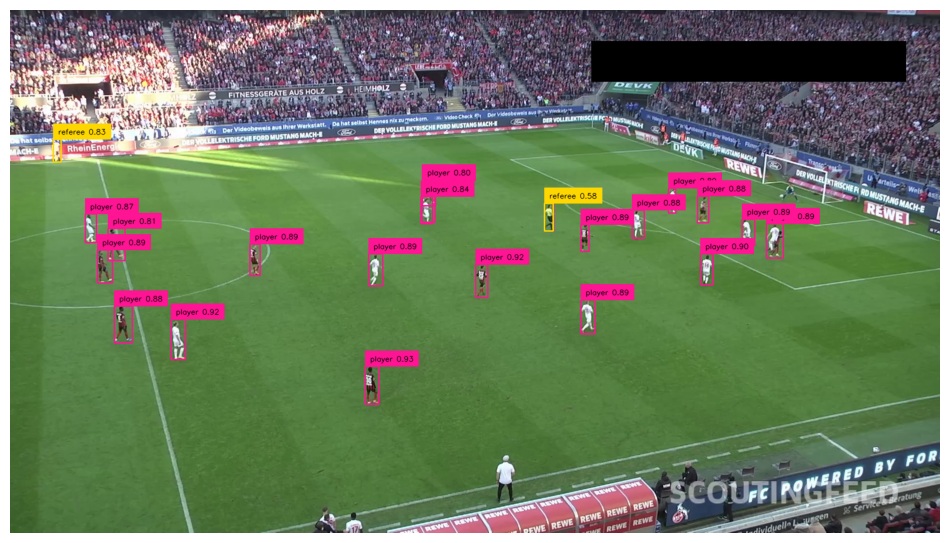

In [18]:
import supervision as sv

box_annotator =  sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

if model_type == 'roboflow':
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence) [0]
    detections = sv.Detections.from_inference(result)


if (model_type == 'local'):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence) [0]
    detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)


sv.plot_image(annotated_frame)

##### Rodando em video.

In [ ]:
box_annotator =  sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        if model_type == 'roboflow':
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence) [0]
            detections = sv.Detections.from_inference(result)

        if model_type == 'local':
            result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence) [0]
            detections = sv.Detections.from_ultralytics(result)

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
        video_sink.write_frame(annotated_frame)

##### Agora alterando a visão. Substituindo os retangulos por semicirculos.
Em uma imagem:


0: 1024x1280 1 referee, 458.9ms
Speed: 19.2ms preprocess, 458.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1280)


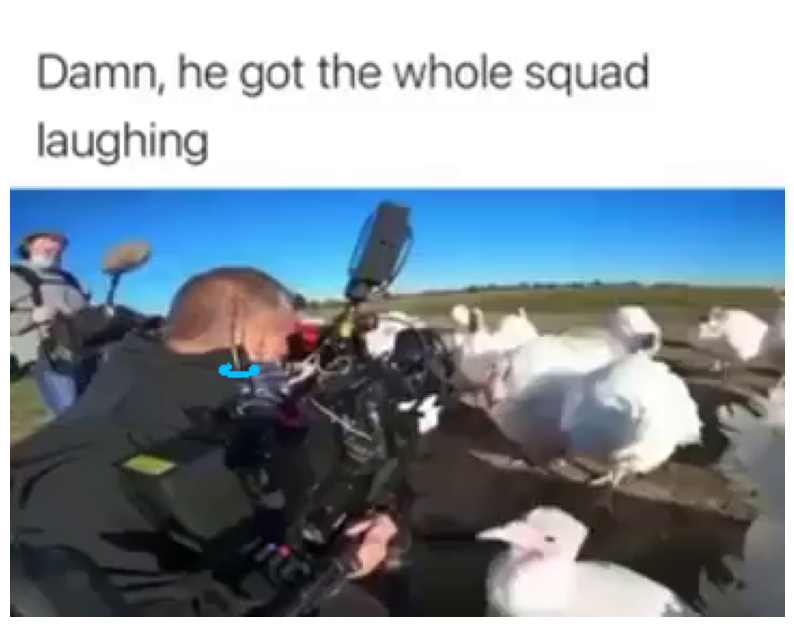

In [24]:
import supervision as sv

BALL_ID = 0

ellipse_annotator =  sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
# label_annotator = sv.LabelAnnotator(
#     color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
#     text_color=sv.Color.from_hex('#000000')
# )
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

if model_type == 'roboflow':
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence) [0]
    detections = sv.Detections.from_inference(result)
if model_type == 'local':
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence) [0]
    detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True) # to remove overlaping detections
all_detections.class_id -= 1


# labels = [
#     f"{class_name} {confidence:.2f}"
#     for class_name, confidence
#     in zip(detections['class_name'], detections.confidence)
# ]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

sv.plot_image(image=annotated_frame, size=(10, 10) )

##### Em video

In [30]:
BALL_ID = 0

ellipse_annotator =  sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        if model_type == 'roboflow':
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence) [0]
            detections = sv.Detections.from_inference(result)
        if model_type == 'local':
            result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence) [0]
            detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True) # to remove overlaping detections
        all_detections.class_id -= 1

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

        video_sink.write_frame(annotated_frame)

100%|██████████| 750/750 [1:08:52<00:00,  5.51s/it]


### Usando o modelo pt2:

#### Tracking

In [ ]:
BALL_ID = 0

ellipse_annotator =  sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        if model_type == 'roboflow':
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence) [0]
            detections = sv.Detections.from_inference(result)
        if model_type == 'local':
            result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence) [0]
            detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True) # to remove overlaping detections
        all_detections.class_id -= 1
        all_detections = tracker.update_with_detections(detections=all_detections)

        labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
        ]

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)

        video_sink.write_frame(annotated_frame)

#### Dividindo os jogadores nos times

##### Iniciando

Criamos uma função pra extrairrecortes dos jogadores, de alguns dos frames do video em questão. Usaremos esses recortes pra treinar o modelo para dividir times.

In [74]:
PLAYER_ID = 2
STRIDE = 30

def extract_crops(source_video_path: str):

    frame_generator = sv.get_video_frames_generator(
        source_path=source_video_path, stride=STRIDE)

    crops = []
    for frame in tqdm(frame_generator, desc='collecting crops'):
        if model_type == 'roboflow':
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence)[0]
            detections = sv.Detections.from_inference(result)
        if model_type == 'local':
            result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence)[0]
            detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
        crops += players_crops
    
    return crops

##### testando se funfou

In [32]:
crops = extract_crops(SOURCE_VIDEO_PATH)

collecting crops: 3it [00:16,  5.40s/it]


In [33]:
len(crops)

60

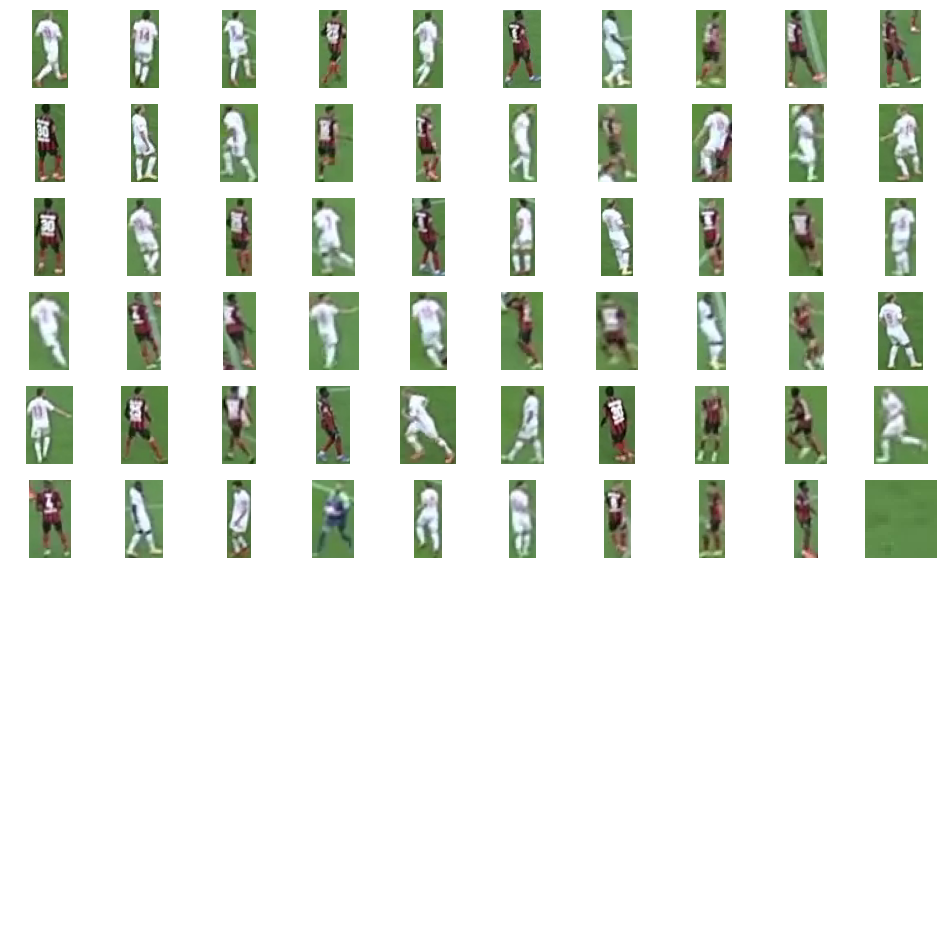

In [34]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

##### Entendendo as entranhas do processo para dividir times

Next, we'll run SigLIP to calculate embeddings for each of the crops.

Atenção. Essa parte a seguir é cópia do que está no repositório de sports do roboflow, o qual usaremos. Foi interessante ver as entranhas, pra entender a complexidade e os metodos usados

In [35]:
import torch
from transformers import AutoProcessor, SiglipVisionModel # type: ignore

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [36]:
import numpy as np
from more_itertools import chunked # type: ignore

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 2it [00:02,  1.25s/it]


In [37]:
data.shape # nos dá o número de exemplos que existem nesse "very high imaginal space with 768 dimensions"

(60, 768)

Agora usaremos o umap pra reduzir essas dimensões, teremos nossos exemplos em um espaço tridimensional.
E então passaremos nossos exemplos em um muito básico e popular clustering algorithm, para apenas 2 clusteres (2 times)

pip install umap-learn
pip install scikit-learn

In [38]:
import umap.umap_ as umap
from sklearn.cluster import KMeans

# agora vamos iniciar o reducer e o clustering model
REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [39]:
projections = REDUCER.fit_transform(data)

In [40]:
projections.shape # verificamos a redução nas dimensões

(60, 3)

Agora, we take those predictions and we pass them into the clustering model, in the method predict. It will first train the clustering model and then run the predictions.

In [41]:
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [42]:
clusters[:10]

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [43]:
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 1
]

In [ ]:
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

##### Utilizando:

###### Inicializando

Ao invés de usar o código que acabamos de escrever, podemos usar o TeamClassifier, do repositório de esportes do roboflow. Internamente é o mesmo que construimos. Mas fica mais fácil de usar do que nosso código por não precisarmos rodar cada passo manualmente.

pip install git+https://github.com/roboflow/sports.git

In [75]:
import numpy as np

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

###### Utilizando em um frame só

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 21 players, 2 referees, 151.6ms
Speed: 10.7ms preprocess, 151.6ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:01,  1.22s/it]


0: 736x1280 24 players, 3 referees, 150.5ms
Speed: 3.7ms preprocess, 150.5ms inference, 21.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:01,  1.52it/s]


0: 736x1280 22 players, 2 referees, 150.6ms
Speed: 6.0ms preprocess, 150.6ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:01,  1.69it/s]
Embedding extraction: 2it [00:02,  1.28s/it]



0: 736x1280 21 players, 2 referees, 317.9ms
Speed: 7.1ms preprocess, 317.9ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  1.51it/s]


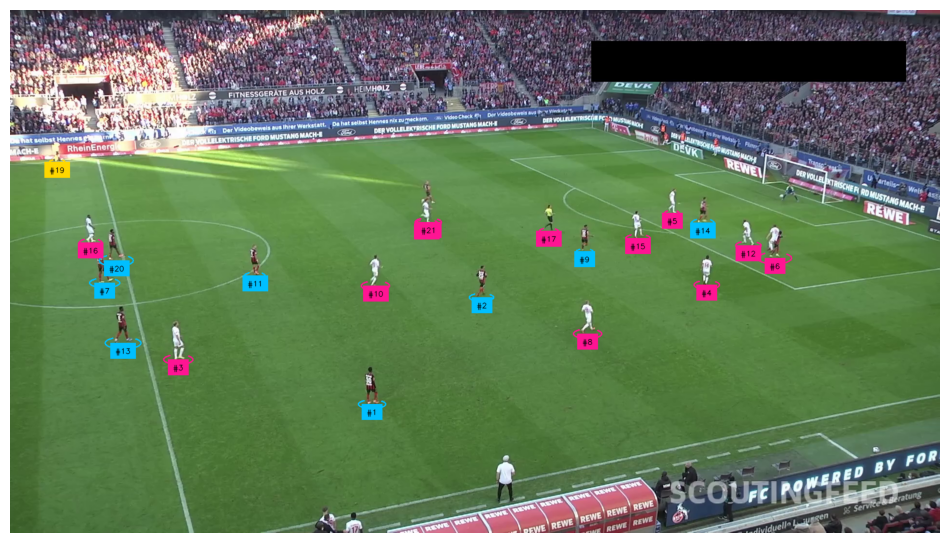

In [66]:
from sports.common.team import TeamClassifier
import umap.umap_ as umap
import torch


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3


crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

if model_type == 'roboflow':
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence)[0]
    detections = sv.Detections.from_inference(result)
if model_type == 'local':
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence)[0]
    detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
all_detections.class_id = all_detections.class_id.astype(int)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

sv.plot_image(annotated_frame)


###### Utilizando em um video

video de 10s, no modelo roboflow, levou 38m

In [76]:
from sports.common.team import TeamClassifier
import umap.umap_ as umap
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        if model_type == 'roboflow':
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence)[0]
            detections = sv.Detections.from_inference(result)
        if model_type == 'local':
            result = PLAYER_DETECTION_MODEL.predict(frame, conf=confidence)[0]
            detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections)

        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
        all_detections.class_id = all_detections.class_id.astype(int)

        labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

        video_sink.write_frame(annotated_frame)

collecting crops: 9it [00:52,  5.83s/it]
Embedding extraction: 6it [00:06,  1.17s/it]
  0%|          | 0/258 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.20it/s]
  0%|          | 1/258 [00:08<37:08,  8.67s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.17it/s]
  1%|          | 2/258 [00:17<36:47,  8.62s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.23it/s]
  1%|          | 3/258 [00:26<36:55,  8.69s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:01,  1.07s/it]
  2%|▏         | 4/258 [00:34<36:57,  8.73s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:01,  1.09s/it]
  2%|▏         | 5/258 [00:44<37:57,  9.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.07it/s]
  2%|▏         | 6/258 [00:52<36:52,  8.78s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00